In [1]:
import zipfile
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas
from matplotlib import ticker
from matplotlib.gridspec import GridSpec, SubplotSpec, GridSpecFromSubplotSpec
from pandas import DataFrame

from plot import bootstrap_samples_mean

plt.style.use('seaborn')
plt.style.use('seaborn-paper')
plt.rcParams.update({
    'figure.figsize': (3.6 * 2, 4.),
    'text.usetex': True,
    'legend.borderpad': 0,
    'xtick.bottom': True,
    'xtick.major.size': 2,
    'xtick.minor.size': 1,
    'lines.markersize': 3,
    'lines.linewidth': 0.5,
    'errorbar.capsize': 2,
    'lines.markeredgewidth': 0.8
})

In [2]:
sampling_color = '#555555'
uedd_color = '#006ba4'
tedd_color = '#ff800e'
nedd_g_color = '#ababab'
nedd_ng_color = '#c85200'

In [3]:
def compute_mean_err(index: np.ndarray, df: DataFrame, col: str, default: float = 0.):
    mean = np.full(len(index), default)
    err = np.zeros_like(mean)
    for i, c in enumerate(index):
        rows = df[df['columns'] == c]
        if len(rows):
            samples = bootstrap_samples_mean(rows[col])
            mean[i], err[i] = np.mean(samples), np.std(samples)
    return mean, err

In [4]:
def load_scalability_results(run_id: str) -> Dict:
    zip = zipfile.ZipFile(f'../results/{run_id}.zip')

    # 1-EDD
    uedd = pandas.read_csv(zip.open(f'{run_id}/uind.csv'))

    # Sampling
    sampling = pandas.read_csv(zip.open(f'{run_id}/sampling.csv'))

    # 2-EDD
    tedd = pandas.read_csv(zip.open(f'{run_id}/bootstrap.csv'))
    assert (len(tedd) == len(uedd))
    tedd['columns'] = uedd['columns']

    # n-EDD (no growing stage)
    names = ['id', 'columns', 'exact', 'bootstrap_alpha', 'time', 'tests', 'ind', 'unique_ind', 'timeout'] + list(
        map(lambda i: f'max_{i}', range(9739)))
    nedd_ng = pandas.read_csv(zip.open(f'{run_id}/findg_0.05_1.00_0.csv'), sep=',', names=names, skiprows=1,
                              low_memory=False).dropna(axis=1, how='all')
    nedd_ng_timeouts = nedd_ng[nedd_ng['timeout']].groupby('columns').size()
    nedd_ng_timeouts /= nedd_ng.groupby('columns').size()

    # n-EDD (with growing stage)
    nedd_g = pandas.read_csv(zip.open(f'{run_id}/findg_0.05_1.00_1.csv'), sep=',', names=names, skiprows=1,
                             low_memory=False).dropna(axis=1, how='all')
    nedd_g_timeouts = nedd_g[nedd_g['timeout']].groupby('columns').size()
    nedd_g_timeouts /= nedd_g.groupby('columns').size()

    # Use the uEDD index as a reference
    index = np.sort(uedd['columns'].unique())

    # Use bootstrap to compute the run-time mean and its incertitude
    sampling_mean, sampling_err = compute_mean_err(index, sampling, 'time')
    uedd_time_mean, uedd_time_err = compute_mean_err(index, uedd, 'time')
    tedd_time_mean, tedd_time_err = compute_mean_err(index, tedd, 'time')
    nedd_ng_time_mean, nedd_ng_time_err = compute_mean_err(index, nedd_ng[~nedd_ng['timeout']], 'time', 50.)
    nedd_g_time_mean, nedd_g_time_err = compute_mean_err(index, nedd_g[~nedd_g['timeout']], 'time', 50.)

    # Use bootstrap to compute the acceptance and its incertitude
    uedd_accepted_mean, uedd_accepted_err = compute_mean_err(index, uedd, 'uinds')
    tedd_accepted_mean, tedd_accepted_err = compute_mean_err(index, tedd, 'accepted')
    nedd_ng_accepted_mean, nedd_ng_accepted_err = compute_mean_err(index, nedd_ng[~nedd_ng['timeout']], 'unique_ind')
    nedd_g_accepted_mean, nedd_g_accepted_err = compute_mean_err(index, nedd_g[~nedd_g['timeout']], 'unique_ind')

    return {
        'columns': index,
        'sampling': (sampling_mean, sampling_err),
        'uedd': {
            'time': (uedd_time_mean, uedd_time_err),
            'accepted': (uedd_accepted_mean, uedd_accepted_err)
        },
        'tedd': {
            'time': (tedd_time_mean, tedd_time_err),
            'accepted': (tedd_accepted_mean, tedd_accepted_err)
        },
        'nedd_ng': {
            'time': (nedd_ng_time_mean, nedd_ng_time_err),
            'accepted': (nedd_ng_accepted_mean, nedd_ng_accepted_err),
            'timeouts': nedd_ng_timeouts
        },
        'nedd_g': {
            'time': (nedd_g_time_mean, nedd_g_time_err),
            'accepted': (nedd_g_accepted_mean, nedd_g_accepted_err),
            'timeouts': nedd_g_timeouts
        }
    }

In [5]:
wave = load_scalability_results('wave_20220511')
keel = load_scalability_results('incremental_20220513')
chembl = load_scalability_results('chembl_20220511')

In [6]:
def plot_dataset(fig: plt.Figure, gs: SubplotSpec, results: Dict, title: str, sharey: List = None,
                 bar_width: float = 1., legend: bool = False):
    sub_gs = GridSpecFromSubplotSpec(nrows=5, ncols=1, subplot_spec=gs, hspace=0.25)

    # EDD counts
    ax_counts = fig.add_subplot(sub_gs[0:2])  #, sharey=sharey[0] if sharey else None)
    uedd_line = ax_counts.errorbar(results['columns'], results['uedd']['accepted'][0],
                                   yerr=results['uedd']['accepted'][1], label='1-EDD', color=uedd_color,
                                   marker='.')
    tedd_line = ax_counts.errorbar(results['columns'], results['tedd']['accepted'][0],
                                   yerr=results['tedd']['accepted'][1], label='2-EDD', color=tedd_color,
                                   marker='.')
    nedd_ng_line = ax_counts.errorbar(results['columns'], results['nedd_ng']['accepted'][0],
                                      yerr=results['nedd_ng']['accepted'][1], label='n-EDD', color=nedd_ng_color,
                                      marker='.')
    nedd_g_line = ax_counts.errorbar(results['columns'], results['nedd_g']['accepted'][0],
                                     yerr=results['nedd_g']['accepted'][1], label='n-EDD (grow)', color=nedd_g_color,
                                     marker='.')

    ax_counts.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax_counts.yaxis.grid(True, which='minor', linewidth=0.1)
    plt.setp(ax_counts.get_xticklabels(), visible=False)

    # Time (cumulative)
    ax_time = fig.add_subplot(sub_gs[2:4], sharex=ax_counts)  #, sharey=sharey[1] if sharey else None)
    ax_time.errorbar(results['columns'], results['sampling'][0], yerr=results['sampling'][1], label='Sampling',
                     color=sampling_color, zorder=10, marker='.')
    ax_time.fill_between(results['columns'], results['sampling'][0], color=sampling_color, alpha=0.2)
    bottom = results['sampling'][0]

    acc = bottom + results['uedd']['time'][0]
    ax_time.errorbar(results['columns'], acc, yerr=results['uedd']['time'][1], label='1-EDD time', color=uedd_color,
                     marker='.')
    ax_time.fill_between(results['columns'], bottom, acc, color=uedd_color, alpha=0.2)

    bottom = acc
    acc = bottom + results['tedd']['time'][0]
    ax_time.errorbar(results['columns'], acc, yerr=results['tedd']['time'][1], label='2-EDD', color=tedd_color,
                     marker='.')
    ax_time.fill_between(results['columns'], bottom, acc, color=tedd_color, alpha=0.2)

    bottom = acc
    acc = bottom + results['nedd_ng']['time'][0]
    ax_time.errorbar(results['columns'], acc, yerr=results['nedd_ng']['time'][1], label='n-EDD time',
                     color=nedd_ng_color, marker='.')
    ax_time.fill_between(results['columns'], bottom, acc, color=nedd_ng_color, alpha=0.2)

    acc = bottom + results['nedd_g']['time'][0]
    ax_time.errorbar(results['columns'], acc, yerr=results['nedd_g']['time'][1], label='n-EDD time (grow)',
                     color=nedd_g_color, marker='.')
    ax_time.fill_between(results['columns'], bottom, acc, color=nedd_g_color, alpha=0.2)
    ax_time.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax_time.yaxis.grid(True, which='minor', linewidth=0.1)
    plt.setp(ax_time.get_xticklabels(), visible=False)

    # Timeouts
    ax_timeouts = fig.add_subplot(sub_gs[4], sharex=ax_counts, sharey=sharey[2] if sharey else None)

    ax_timeouts.bar(results['nedd_g']['timeouts'].index + bar_width / 2, results['nedd_g']['timeouts'] * 100,
                    width=bar_width, color=nedd_g_color, label='Growing stage')
    ax_timeouts.bar(results['nedd_ng']['timeouts'].index - bar_width / 2, results['nedd_ng']['timeouts'] * 100,
                    width=bar_width, color=nedd_ng_color, label='No growing stage')
    if legend:
        ax_timeouts.set_xlabel('Columns')
    ax_timeouts.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax_timeouts.yaxis.grid(True, which='minor', linewidth=0.1)
    ax_timeouts.set_ylim(0, 100)
    ax_timeouts.yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:.0f}\%$"))

    if sharey is None:
        ax_counts.set_ylabel('Count')
        ax_time.set_ylabel('Time (s)')
        ax_timeouts.set_ylabel('Timeouts')

    ax_counts.set_title(title)
    fig.align_ylabels([ax_counts, ax_time, ax_timeouts])

    if legend:
        ax_timeouts.legend(handles=[uedd_line, tedd_line, nedd_ng_line, nedd_g_line], loc='lower center',
                           bbox_to_anchor=(0.5, -1.4), ncol=4)

    return [ax_counts, ax_time, ax_timeouts]

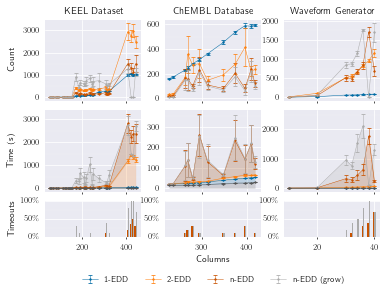

In [7]:
fig = plt.figure()

gs = GridSpec(nrows=1, ncols=3, wspace=0.25)

axes = plot_dataset(fig, gs[0], keel, title='KEEL Dataset', bar_width=5)
plot_dataset(fig, gs[1], chembl, title='ChEMBL Database', sharey=axes, bar_width=3, legend=True)
plot_dataset(fig, gs[2], wave, title='Waveform Generator', sharey=axes, bar_width=0.5)

fig.savefig('/home/aalvarez/Downloads/scalability.pdf', bbox_inches='tight', pad_inches=0.05)